# AMG - Population change analysis

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Gather data

### Population change data and time to masive public transport stop

In [2]:
c = 'Monterrey'
res = 8

In [3]:
grl_dir = '/home/edgaregurrola/SIG/ObsCds/Proyectos/Vivienda_Deshabitada/'
hex_pop = gpd.read_file(grl_dir+f'Info_Sociodemografica/Analisis/Block_Census/{c}_Census_10_20_BlockAnalysis_res{res}.geojson', driver='GeoJSON')
hex_tp = gpd.read_file(grl_dir+f'/Medio_Urbano/Transporte_Publico/{c}_HexRes{res}_MassPublicTransport.geojson', driver='GeoJSON')

In [4]:
print(hex_pop.shape)
hex_pop.head(2)

(1490, 430)


,hex_id_8,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,...,Z_RTViv_10_20,R_VivHab_20,R_VivDes_20,Z_RVivHab_20,R_VivHab_10,Z_RVivHab_10,Chng_RVivHab_10,R_TVivDes_10_20,DensPob_10_20,geometry
0,8848a205b1fffff,10619.0,5338.0,5281.0,447.0,156.0,187.0,10127.0,5100.0,5027.0,...,None,0.898835,0.059779,0.660828,0.0,None,0.898835,None,41.426663,"POLYGON ((-100.33358 25.79790, -100.32883 25.8..."
1,8848a21105fffff,304.0,136.0,156.0,4.0,0.0,3.0,129.0,52.0,75.0,...,None,0.793388,0.049587,0.158093,0.0,None,0.793388,None,2.413829,"POLYGON ((-100.16099 25.45600, -100.15625 25.4..."


In [5]:
print(hex_tp.shape)
hex_tp.head(2)

(3807, 20)


,idx_accessibility,idx_hospitales,idx_supermercado,idx_farmacias,node_count,wAcc,wHsp,wSpm,wFrm,idx_accessibility_wavg,idx_hospitales_wavg,idx_supermercado_wavg,idx_farmacias_wavg,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados,time_paradas_transporte,geometry
0,1.711254e-07,5.137917e-07,9.834111e-11,1.438756e-15,1,1.711254e-07,5.137917e-07,9.834111e-11,1.438756e-15,8.104983e-13,2.433463e-12,4.657714e-16,6.814356e-21,8848a22169fffff,19001,6093.8030,16181.609000,4320.4980,429.541841,"POLYGON ((-100.41315 25.97324, -100.41271 25.9..."
1,1.213268e-07,2.810359e-07,8.171950e-08,1.584510e-09,6,7.279607e-07,1.686215e-06,4.903170e-07,9.507062e-09,3.447828e-12,7.986395e-12,2.322280e-12,4.502814e-14,8848a22321fffff,19001,4148.9265,16763.191333,3262.2445,415.818870,"POLYGON ((-100.43044 25.94069, -100.42568 25.9..."


In [6]:
idx = hex_tp.time_paradas_transporte>0
hex_tp = hex_tp[idx].copy()

In [7]:
hex_pop = hex_pop[['hex_id_8','T_Pob_10_20','T_Viv_10_20','R_VivDes_20']].copy()

<AxesSubplot:>

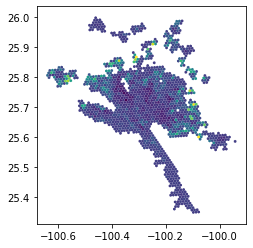

In [8]:
hex_merge = hex_tp.merge(hex_pop, on='hex_id_8')
hex_merge.plot('T_Pob_10_20')

<AxesSubplot:>

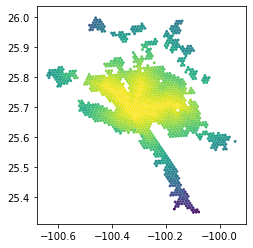

In [9]:
hex_merge.plot('time_paradas_transporte', 'viridis_r')

## Filter data

### Less than 30 min vs More than 30 min

In [10]:
sample = 30
gdf_near_tp = hex_merge[hex_merge.time_paradas_transporte<=30].sample(n=sample)
gdf_far_tp = hex_merge[hex_merge.time_paradas_transporte>30].sample(n=sample)

## Analyzing means

In [11]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Menos de 30 minutos: {gdf_near_tp.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos: {gdf_far_tp.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Menos de 30 minutos: -422.6666666666667 personas
Más de 30 minutos: 939.3333333333334 personas


## Boxplot

In [12]:
box_plot_tp_analysis = gdf_near_tp.copy()
box_plot_tp_analysis['distance_tp'] = 'Menos de 30 minutos'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_tp)
idx = box_plot_tp_analysis['distance_tp'].isna()
box_plot_tp_analysis.loc[idx, 'distance_tp'] = 'Más de 30 minutos'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

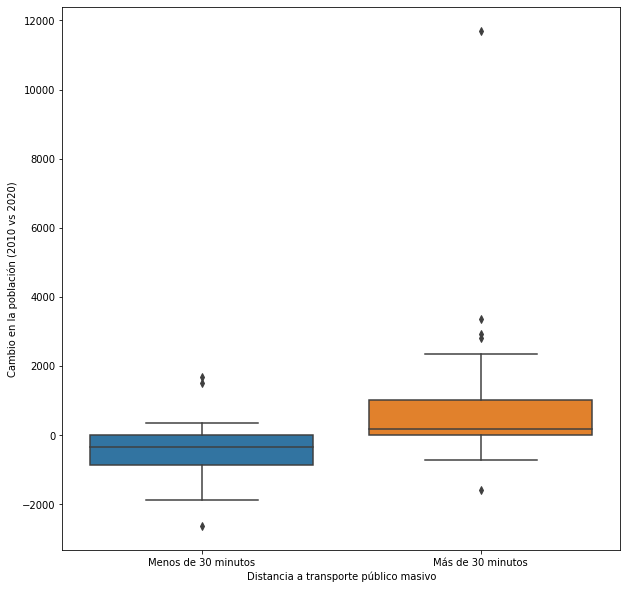

In [13]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.distance_tp)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Distancia a transporte público masivo')
plt.ylabel('Cambio en la población (2010 vs 2020)')

## t-test

In [14]:
stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)

Ttest_indResult(statistic=-3.0220176021142033, pvalue=0.0037331896395717233)

## Inner periférico - near vs far to public transport

In [15]:
hex_peri = gpd.read_file(grl_dir+'/Medio_Urbano/Vias_Transporte/AMG_HexRes8_Periferico_GCS_OC22_v1.geojson', driver='GeoJSON')
print(hex_peri.shape)
hex_peri.head(2)

(1160, 4)


,fid,hex_id_8,Periferico,geometry
0,1,8849aa2d99fffff,1,"POLYGON ((-103.32340 20.57940, -103.31887 20.5..."
1,2,88498c95cbfffff,0,"POLYGON ((-103.29386 20.71601, -103.28932 20.7..."


<AxesSubplot:>

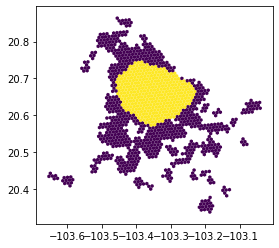

In [16]:
hex_merge_peri = hex_merge.merge(hex_peri[['hex_id_8','Periferico']], on='hex_id_8')
hex_merge_peri.plot('Periferico')

In [17]:
sample = 50
gdf_near_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2<=30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)
gdf_far_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)

In [18]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Menos de 30 minutos: {gdf_near_tp.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos: {gdf_far_tp.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Menos de 30 minutos: -763.12 personas
Más de 30 minutos: 93.12 personas


In [19]:
box_plot_tp_analysis = gdf_near_tp.copy()
box_plot_tp_analysis['distance_tp'] = 'Menos de 30 minutos'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_tp)
idx = box_plot_tp_analysis['distance_tp'].isna()
box_plot_tp_analysis.loc[idx, 'distance_tp'] = 'Más de 30 minutos'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

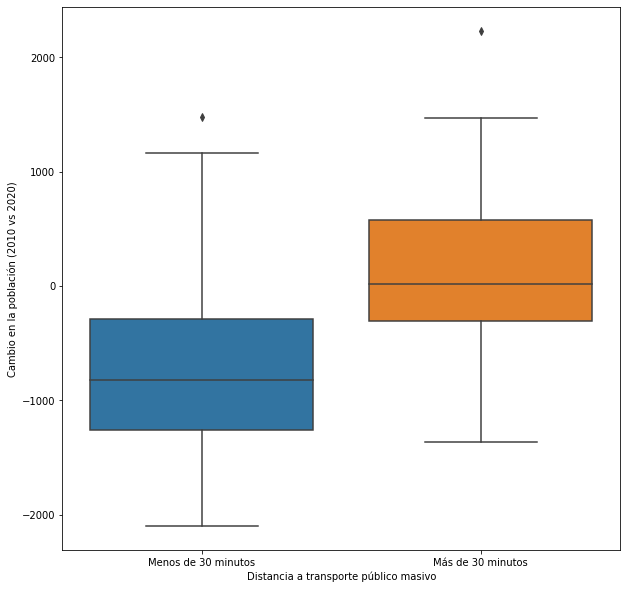

In [20]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.distance_tp)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Distancia a transporte público masivo')
plt.ylabel('Cambio en la población (2010 vs 2020)')

In [21]:
stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)

Ttest_indResult(statistic=-5.657873085341411, pvalue=1.5209027671037144e-07)

In [22]:
dict_tmp = {}

for i in range(100):
    sample = 50
    gdf_near_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2<=30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    gdf_far_tp = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    
    _, pvalue = stats.ttest_ind(gdf_near_tp.T_Pob_10_20, gdf_far_tp.T_Pob_10_20)
    
    dict_tmp[i] = {'mean_near':gdf_near_tp.T_Pob_10_20.mean(),
                  'mean_far':gdf_far_tp.T_Pob_10_20.mean(),
                  'pvalue':pvalue}

In [23]:
df_ttest = pd.DataFrame.from_dict(dict_tmp).transpose()
print(df_ttest.shape)
df_ttest.head(2)

(100, 3)


,mean_near,mean_far,pvalue
0,-631.0,46.74,0.000370
1,-692.9,-100.64,0.001196


In [24]:
idx = df_ttest.pvalue > 0.025
df_ttest[idx]

,mean_near,mean_far,pvalue
11,-552.52,-176.94,0.038432
23,-546.72,-138.20,0.036893
94,-443.74,-164.14,0.153052
97,-509.02,-126.62,0.064001


In [25]:
idx = df_ttest.mean_near > df_ttest.mean_far
df_ttest[idx]

,mean_near,mean_far,pvalue


### Population change for iterations

<AxesSubplot:>

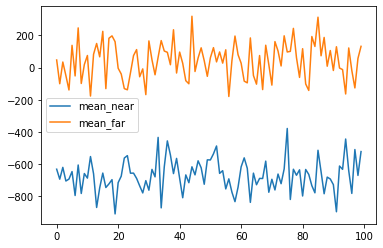

In [26]:
df_ttest[['mean_near','mean_far']].plot()

## Inner vs outter periphery for > 30 min to mass public transport

In [27]:
sample = 50
gdf_far_inner = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==1)].sample(n=sample)
gdf_far_outter = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                       (hex_merge_peri.Periferico==0)].sample(n=sample)

In [28]:
print("Promedio de cambio de población por distancia a transporte público masivo")
print(f"Más de 30 minutos fuera de periférico: {gdf_far_outter.T_Pob_10_20.mean()} personas")
print(f"Más de 30 minutos dentro de periférico: {gdf_far_inner.T_Pob_10_20.mean()} personas")

Promedio de cambio de población por distancia a transporte público masivo
Más de 30 minutos fuera de periférico: 1094.6 personas
Más de 30 minutos dentro de periférico: -147.58 personas


In [29]:
box_plot_tp_analysis = gdf_far_inner.copy()
box_plot_tp_analysis['periferico'] = 'Dentro de periférico'
box_plot_tp_analysis = box_plot_tp_analysis.append(gdf_far_outter)
idx = box_plot_tp_analysis['periferico'].isna()
box_plot_tp_analysis.loc[idx, 'periferico'] = 'Fuera de periférico'

Text(0, 0.5, 'Cambio en la población (2010 vs 2020)')

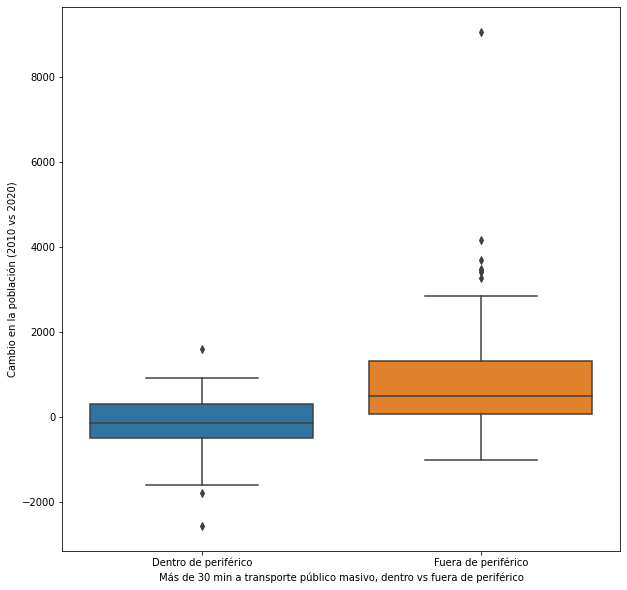

In [30]:
gdf_nearfig, ax = plt.subplots(figsize=(10,10))

x = np.array(box_plot_tp_analysis.periferico)
y = np.array(box_plot_tp_analysis.T_Pob_10_20)

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Más de 30 min a transporte público masivo, dentro vs fuera de periférico')
plt.ylabel('Cambio en la población (2010 vs 2020)')

In [31]:
stats.ttest_ind(gdf_far_inner.T_Pob_10_20, gdf_far_outter.T_Pob_10_20)

Ttest_indResult(statistic=-4.770990948030626, pvalue=6.396764733152454e-06)

In [32]:
dict_tmp = {}

for i in range(100):
    sample = 50
    gdf_far_inner = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==1)].sample(n=sample)
    gdf_far_outter = hex_merge_peri[(hex_merge_peri.time_transporte_masivo_V2>30)&
                           (hex_merge_peri.Periferico==0)].sample(n=sample)
    
    _, pvalue = stats.ttest_ind(gdf_far_inner.T_Pob_10_20, gdf_far_outter.T_Pob_10_20)
    
    dict_tmp[i] = {'mean_inner':gdf_far_inner.T_Pob_10_20.mean(),
                  'mean_outter':gdf_far_outter.T_Pob_10_20.mean(),
                  'pvalue':pvalue}

In [33]:
df_ttest = pd.DataFrame.from_dict(dict_tmp).transpose()
print(df_ttest.shape)
df_ttest.head(2)

(100, 3)


,mean_inner,mean_outter,pvalue
0,-16.66,976.08,0.000055
1,35.50,1059.66,0.000031


In [34]:
idx = df_ttest.pvalue > 0.025
df_ttest[idx]

,mean_inner,mean_outter,pvalue
20,307.40,1037.66,0.067480
56,260.42,688.46,0.041676
60,207.62,804.18,0.077013
74,270.80,633.28,0.094787


In [35]:
idx = df_ttest.mean_inner > df_ttest.mean_outter
df_ttest[idx]

,mean_inner,mean_outter,pvalue


### Population change for iteratons

<AxesSubplot:>

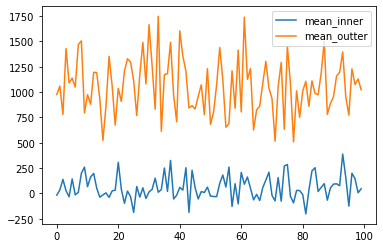

In [36]:
df_ttest[['mean_inner','mean_outter']].plot()

## Distance vs population change

In [15]:
x = np.array(hex_merge.time_paradas_transporte)
y = np.array(hex_merge.T_Pob_10_20)
np.corrcoef(x, y)

array([[1.        , 0.06819177],
       [0.06819177, 1.        ]])

### Scatter - density plot

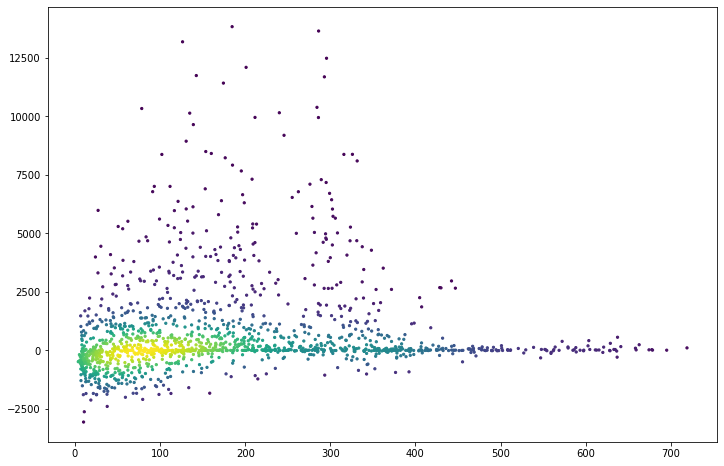

In [16]:

fig, ax = plt.subplots(figsize=(12,8))


# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

ax.scatter(x, y, c=z, s=5)
plt.show()

In [17]:
from time import sleep

In [4]:
from random import randint

In [1]:
from geopy.geocoders import Nominatim

In [2]:
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

In [5]:
user_agent = 'user_me_{}'.format(randint(10000,99999))
geolocator = Nominatim(user_agent=user_agent)

In [6]:
geolocator

In [7]:
def reverse_geocode(geolocator, latlon, sleep_sec):
    try:
        return geolocator.reverse(latlon)
    except GeocoderTimedOut:
        logging.info('TIMED OUT: GeocoderTimedOut: Retrying...')
        sleep(randint(1*100,sleep_sec*100)/100)
        return reverse_geocode(geolocator, latlon, sleep_sec)
    except GeocoderServiceError as e:
        logging.info('CONNECTION REFUSED: GeocoderServiceError encountered.')
        logging.error(e)
        return None
    except Exception as e:
        logging.info('ERROR: Terminating due to exception {}'.format(e))
        return None

In [8]:
latlon =  (20.696220, -103.397090)

In [10]:
reverse_geocode(geolocator, latlon,1)

Location(1453, Avenida Acueducto, Colinas de San Javier, Guadalajara, Jalisco, 44647, México, (20.6966942, -103.3970612, 0.0))

In [11]:
geolocator.geocode('1453, Avenida Acueducto, Colinas de San Javier, Guadalajara, Jalisco, 44647, México')

Location(1453, Avenida Acueducto, Colinas de San Javier, Guadalajara, Jalisco, 44647, México, (20.6966942, -103.3970612, 0.0))

In [13]:
geolocator.geocode('Colinas de San Javier, Guadalajara, Jalisco')

Location(Colinas de San Javier, Guadalajara, Jalisco, 45054, México, (20.7030517, -103.4022405, 0.0))